# Sheet 4 - Practical Part

## a) Vanishing Gradients

In [208]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
from functools import partial
from pathlib import Path
from torch.utils.data import DataLoader, ConcatDataset
from load_mnist import load_mnist

In [209]:
class CUDADataLoader:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        
    def __iter__(self):
        for images, labels in self.dataloader:
            yield [images.to('cuda:0'), labels.to('cuda:0')]
            
    def __len__(self):
        return len(self.dataloader)
    
    @property
    def dataset(self):
        return self.dataloader.dataset

In [210]:
dataset_path = '../data/fashion_mnist'

class FashionMNIST:
    def __init__(self, dataset, filter_class=None, sort=False):
        self.images, self.labels = load_mnist(dataset, dataset_path)
        self.images = self.images.flatten(1)
        self.labels = self.labels.long()
        self.std, self.mean = torch.std_mean(self.images, dim=0)
        
        # filter and sort
        if filter_class is not None:
            self.images = self.images[self.labels == filter_class]
            self.labels = self.labels[self.labels == filter_class]
            
        if sort:
            sort_indices = torch.argsort(self.labels)
            self.images = self.images[sort_indices]
            self.labels = self.labels[sort_indices]
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = (self.images[index] - self.mean) / (self.std + 1e-10)
        return image, self.labels[index]

In [211]:
def MLPClassifier(input_size, output_size, num_neurons, activation_type=nn.Identity, initializer=None):
    layers = [nn.Flatten(1)]
    last_layer_neurons = input_size

    for i, layer_neurons in enumerate(num_neurons):
        layer = nn.Linear(last_layer_neurons, layer_neurons)
        
        if initializer is not None:
            initializer(layer.weight)
        
        layers.append(layer)
        layers.append(activation_type())
        last_layer_neurons = layer_neurons

    layers.append(nn.Linear(last_layer_neurons, output_size))
    return nn.Sequential(*layers)

In [212]:
def train(model, dataloader, optimizer):
    for image_batch, label_batch in dataloader:
        optimizer.zero_grad()
        predictions = model(image_batch)
        loss = F.cross_entropy(predictions, label_batch)
        loss.backward()
        optimizer.step()

def accuracy(model, dataloader):
    hits = num_batches = 0
    for image_batch, label_batch in dataloader:
        predictions = predict(model, image_batch)
        hits += (predictions == label_batch).count_nonzero()
        
    return hits / len(dataloader.dataset)

In [213]:
train_dataloader = CUDADataLoader(DataLoader(FashionMNIST('training'), batch_size=64, shuffle=True, pin_memory=True))
test_dataloader = CUDADataLoader(DataLoader(FashionMNIST('testing'), batch_size=1_024, pin_memory=True))

In [214]:
# do one training & collection step
def train_and_collect_gradients(model, dataloader, optimizer):
    num_parameters = sum(1 for _ in model.parameters())
    gradient_norms = np.zeros((len(dataloader), num_parameters))
    
    for grad_norms_i, (image_batch, label_batch) in zip(gradient_norms, dataloader):
        optimizer.zero_grad()
        predictions = model(image_batch)
        loss = F.cross_entropy(predictions, label_batch)
        loss.backward()
        optimizer.step()
        grad_norms_i[:] = [p.grad.norm().cpu().detach().numpy().copy() for p in model.parameters()]
        
    return gradient_norms.mean(axis=0)

In [215]:
# train a model for a given number of epochs and collect gradients
def run_gradient_collection_for_model(model, optimizer, num_epochs=20):
    num_parameters = sum(1 for _ in model.parameters())
    gradient_norms = np.zeros((num_epochs, num_parameters))
    accuracies = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        gradient_norms[epoch] = train_and_collect_gradients(model, train_dataloader, optimizer)
        accuracies[epoch] = accuracy(model, test_dataloader)
        print(f"{epoch=:<2} accuracy={accuracies[epoch]:.4f}")
        
    return gradient_norms, accuracies

In [216]:
# collect gradients for all configurations: (50,), (50,30), (50,30,30), (50,30,30,30)
def run_configurations_for_gradient_collection(activation_type, initializer_fn=None):
    gradient_norms = []
    accuracies = []

    for num_additional_layers in range(4):
        print(f" --- TRAIN WITH {num_additional_layers} ADDITIONAL LAYER(S) ---")
        num_neurons = (50,) + (30,) * num_additional_layers
        model = MLPClassifier(784, 10, num_neurons, activation_type, initializer_fn).to('cuda:0')
        optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
        grad_norms, accs = run_gradient_collection_for_model(model, optimizer)

        gradient_norms.append(grad_norms)
        accuracies.append(accs)
        
    return gradient_norms, accuracies

In [217]:
# create accuracy plot
def plot_accuracies(accuracies, activation_name):
    plt.figure(figsize=(10, 10))

    for num_additional_layers, conf_accuracies in enumerate(accuracies):
        name = "(50" + ",30"*num_additional_layers+")"
        plt.plot(conf_accuracies, label=name)

    plt.legend()
    plt.title(f"configurations with {activation_name}")
    plt.show()

In [218]:
# create plots for gradient norms
def plot_gradient_norms(gradient_norms, activation_name):
    _, axs = plt.subplots(2,2, figsize=(14,14))

    y_min = min(gn.min() for gn in gradient_norms)
    y_max = max(gn.max() for gn in gradient_norms)

    for num_additional_layers, (conf_norms, ax) in enumerate(zip(gradient_norms, axs.ravel())):
        name = "(50" + ",30"*num_additional_layers+")"

        for pi in range(0,conf_norms.shape[1],2):    
            param_name = f"layer {pi//2 + 1} " + ("weight matrix" if pi % 2 == 0 else "bias vector")
            ax.plot(conf_norms[:, pi], label=param_name)

        ax.legend()
        ax.set_ylim(y_min, y_max)
        ax.set_title(f"gradient norms of {name} with {activation_name}")

    plt.show()

### Models with Sigmoid

In [219]:
gradient_norms, accuracies = run_configurations_for_gradient_collection(nn.Sigmoid)

 --- TRAIN WITH 0 ADDITIONAL LAYER(S) ---
epoch=0  accuracy=0.6945
epoch=1  accuracy=0.7294
epoch=2  accuracy=0.7431
epoch=3  accuracy=0.7545
epoch=4  accuracy=0.7666
epoch=5  accuracy=0.7777
epoch=6  accuracy=0.7875
epoch=7  accuracy=0.7943
epoch=8  accuracy=0.7995
epoch=9  accuracy=0.8080
epoch=10 accuracy=0.8125
epoch=11 accuracy=0.8150
epoch=12 accuracy=0.8177
epoch=13 accuracy=0.8206
epoch=14 accuracy=0.8231
epoch=15 accuracy=0.8257
epoch=16 accuracy=0.8273
epoch=17 accuracy=0.8295
epoch=18 accuracy=0.8306
epoch=19 accuracy=0.8323
 --- TRAIN WITH 1 ADDITIONAL LAYER(S) ---
epoch=0  accuracy=0.4369
epoch=1  accuracy=0.4221
epoch=2  accuracy=0.4516
epoch=3  accuracy=0.5129
epoch=4  accuracy=0.5335
epoch=5  accuracy=0.5692
epoch=6  accuracy=0.5864
epoch=7  accuracy=0.6032
epoch=8  accuracy=0.6086
epoch=9  accuracy=0.6377
epoch=10 accuracy=0.6571
epoch=11 accuracy=0.6762
epoch=12 accuracy=0.6972
epoch=13 accuracy=0.7156
epoch=14 accuracy=0.7263
epoch=15 accuracy=0.7348
epoch=16 accurac

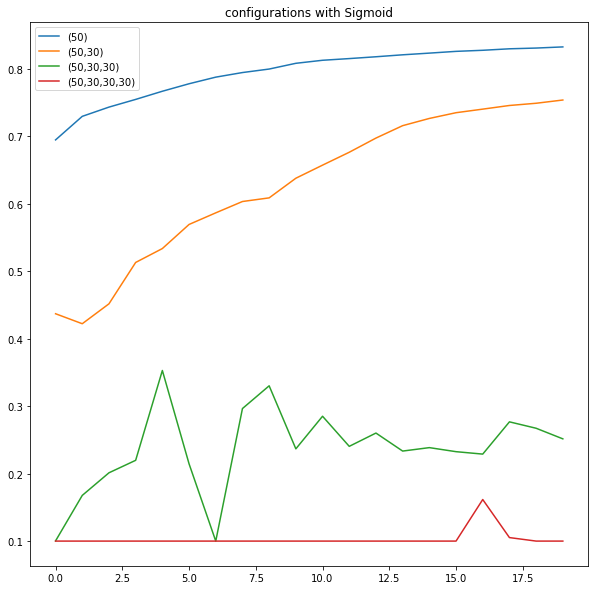

In [220]:
plot_accuracies(accuracies, "Sigmoid")

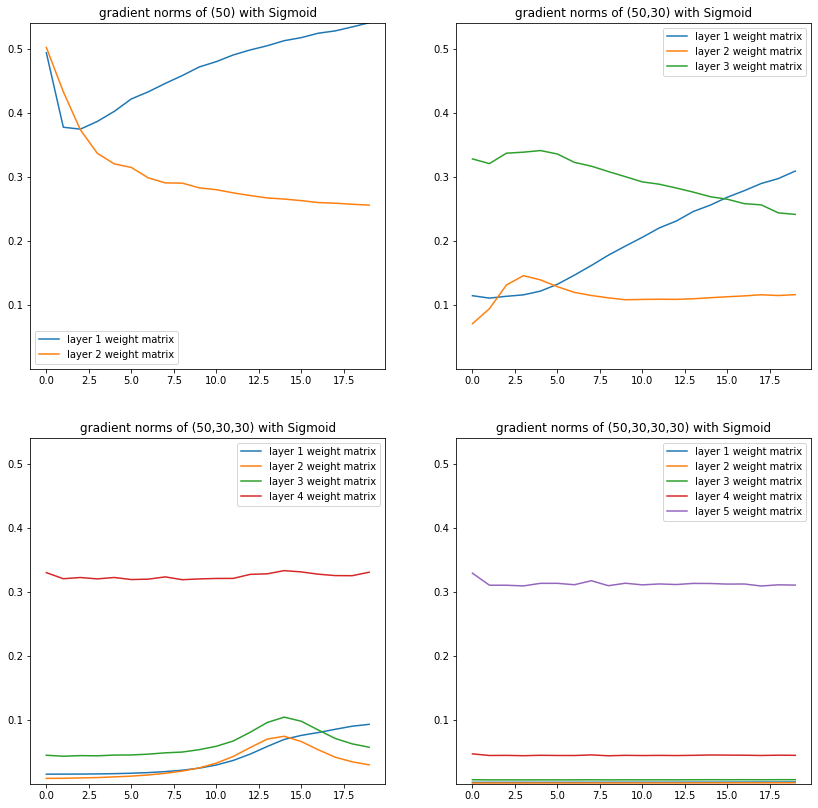

In [221]:
plot_gradient_norms(gradient_norms, "Sigmoid")

### Models with ReLU

In [222]:
gradient_norms, accuracies = run_configurations_for_gradient_collection(nn.ReLU)

 --- TRAIN WITH 0 ADDITIONAL LAYER(S) ---
epoch=0  accuracy=0.7803
epoch=1  accuracy=0.8108
epoch=2  accuracy=0.8235
epoch=3  accuracy=0.8318
epoch=4  accuracy=0.8387
epoch=5  accuracy=0.8433
epoch=6  accuracy=0.8454
epoch=7  accuracy=0.8448
epoch=8  accuracy=0.8476
epoch=9  accuracy=0.8507
epoch=10 accuracy=0.8541
epoch=11 accuracy=0.8543
epoch=12 accuracy=0.8578
epoch=13 accuracy=0.8580
epoch=14 accuracy=0.8605
epoch=15 accuracy=0.8608
epoch=16 accuracy=0.8621
epoch=17 accuracy=0.8618
epoch=18 accuracy=0.8629
epoch=19 accuracy=0.8644
 --- TRAIN WITH 1 ADDITIONAL LAYER(S) ---
epoch=0  accuracy=0.7366
epoch=1  accuracy=0.7799
epoch=2  accuracy=0.8104
epoch=3  accuracy=0.8235
epoch=4  accuracy=0.8335
epoch=5  accuracy=0.8379
epoch=6  accuracy=0.8428
epoch=7  accuracy=0.8455
epoch=8  accuracy=0.8497
epoch=9  accuracy=0.8506
epoch=10 accuracy=0.8545
epoch=11 accuracy=0.8567
epoch=12 accuracy=0.8580
epoch=13 accuracy=0.8571
epoch=14 accuracy=0.8617
epoch=15 accuracy=0.8609
epoch=16 accurac

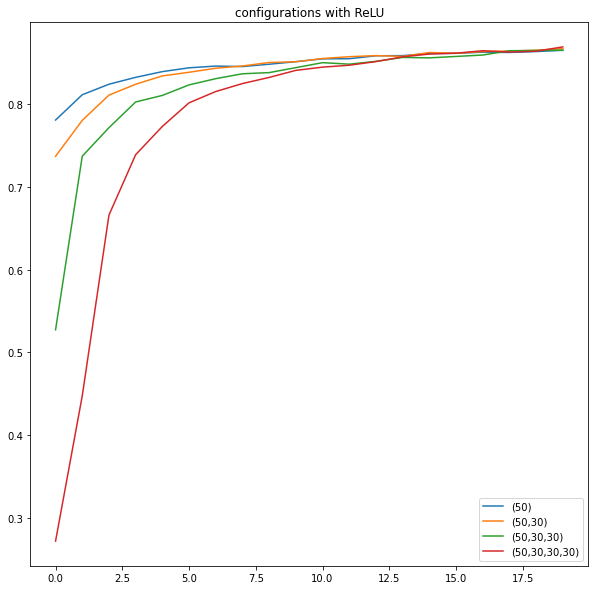

In [223]:
plot_accuracies(accuracies, "ReLU")

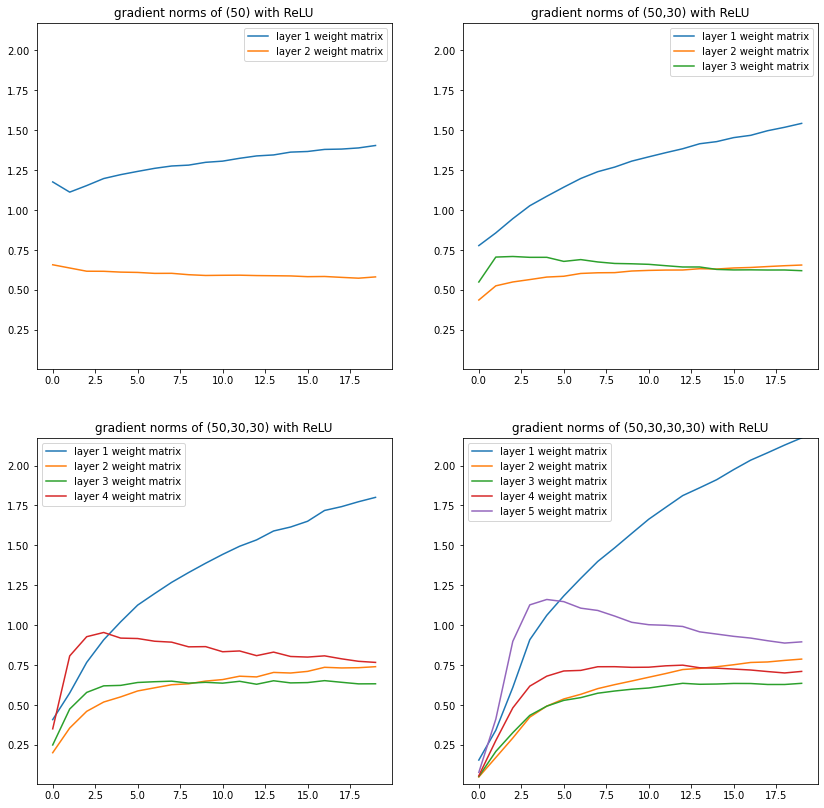

In [224]:
plot_gradient_norms(gradient_norms, "ReLU")

### Models with Sigmoid + Xavier

In [225]:
gradient_norms, accuracies = run_configurations_for_gradient_collection(nn.Sigmoid, nn.init.xavier_normal_)

 --- TRAIN WITH 0 ADDITIONAL LAYER(S) ---
epoch=0  accuracy=0.6838
epoch=1  accuracy=0.7280
epoch=2  accuracy=0.7463
epoch=3  accuracy=0.7576
epoch=4  accuracy=0.7669
epoch=5  accuracy=0.7753
epoch=6  accuracy=0.7842
epoch=7  accuracy=0.7914
epoch=8  accuracy=0.7985
epoch=9  accuracy=0.8023
epoch=10 accuracy=0.8071
epoch=11 accuracy=0.8118
epoch=12 accuracy=0.8151
epoch=13 accuracy=0.8181
epoch=14 accuracy=0.8204
epoch=15 accuracy=0.8231
epoch=16 accuracy=0.8249
epoch=17 accuracy=0.8279
epoch=18 accuracy=0.8300
epoch=19 accuracy=0.8310
 --- TRAIN WITH 1 ADDITIONAL LAYER(S) ---
epoch=0  accuracy=0.4945
epoch=1  accuracy=0.5409
epoch=2  accuracy=0.6108
epoch=3  accuracy=0.6306
epoch=4  accuracy=0.6289
epoch=5  accuracy=0.6499
epoch=6  accuracy=0.6777
epoch=7  accuracy=0.7018
epoch=8  accuracy=0.7079
epoch=9  accuracy=0.7176
epoch=10 accuracy=0.7301
epoch=11 accuracy=0.7334
epoch=12 accuracy=0.7399
epoch=13 accuracy=0.7471
epoch=14 accuracy=0.7523
epoch=15 accuracy=0.7563
epoch=16 accurac

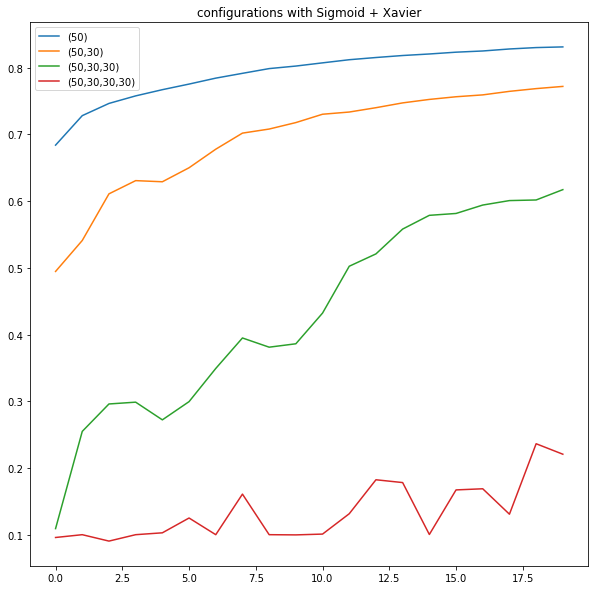

In [226]:
plot_accuracies(accuracies, "Sigmoid + Xavier")

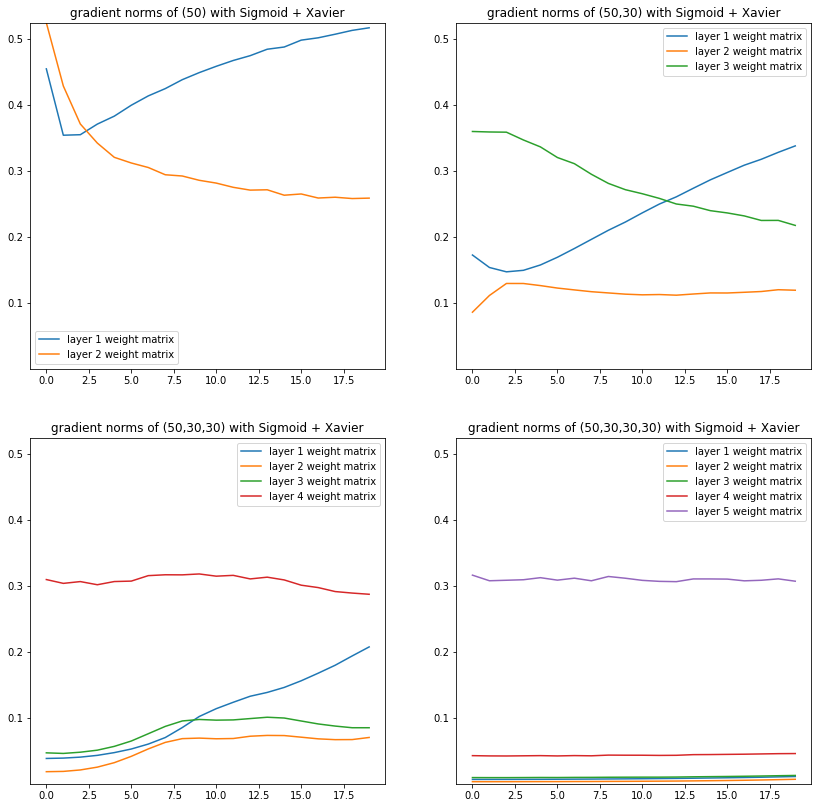

In [227]:
plot_gradient_norms(gradient_norms, "Sigmoid + Xavier")

### Models with Sigmoid + improved Kaiming / He

In [228]:
improved_initializer = partial(nn.init.kaiming_uniform_, a=np.sqrt(5), nonlinearity='sigmoid')
gradient_norms, accuracies = run_configurations_for_gradient_collection(nn.Sigmoid, improved_initializer)

 --- TRAIN WITH 0 ADDITIONAL LAYER(S) ---
epoch=0  accuracy=0.6845
epoch=1  accuracy=0.7315
epoch=2  accuracy=0.7511
epoch=3  accuracy=0.7621
epoch=4  accuracy=0.7719
epoch=5  accuracy=0.7821
epoch=6  accuracy=0.7909
epoch=7  accuracy=0.7962
epoch=8  accuracy=0.8027
epoch=9  accuracy=0.8068
epoch=10 accuracy=0.8113
epoch=11 accuracy=0.8139
epoch=12 accuracy=0.8166
epoch=13 accuracy=0.8205
epoch=14 accuracy=0.8226
epoch=15 accuracy=0.8247
epoch=16 accuracy=0.8266
epoch=17 accuracy=0.8286
epoch=18 accuracy=0.8292
epoch=19 accuracy=0.8302
 --- TRAIN WITH 1 ADDITIONAL LAYER(S) ---
epoch=0  accuracy=0.4731
epoch=1  accuracy=0.5080
epoch=2  accuracy=0.5670
epoch=3  accuracy=0.5893
epoch=4  accuracy=0.6056
epoch=5  accuracy=0.6051
epoch=6  accuracy=0.6129
epoch=7  accuracy=0.6501
epoch=8  accuracy=0.6788
epoch=9  accuracy=0.7025
epoch=10 accuracy=0.7211
epoch=11 accuracy=0.7293
epoch=12 accuracy=0.7384
epoch=13 accuracy=0.7439
epoch=14 accuracy=0.7478
epoch=15 accuracy=0.7515
epoch=16 accurac

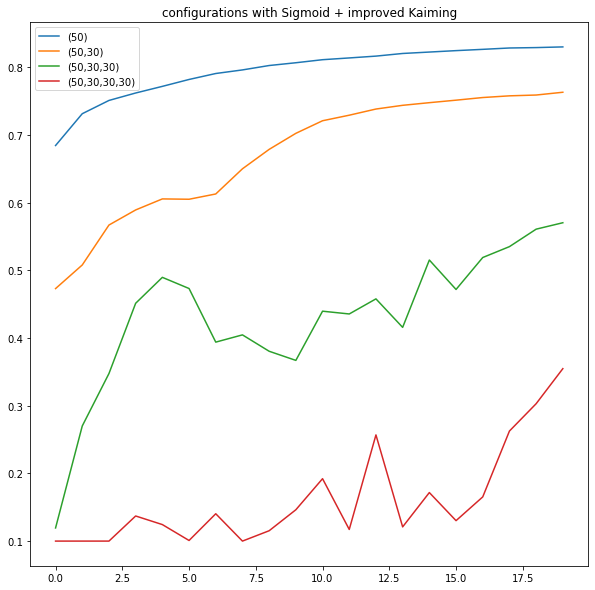

In [229]:
plot_accuracies(accuracies, "Sigmoid + improved Kaiming")

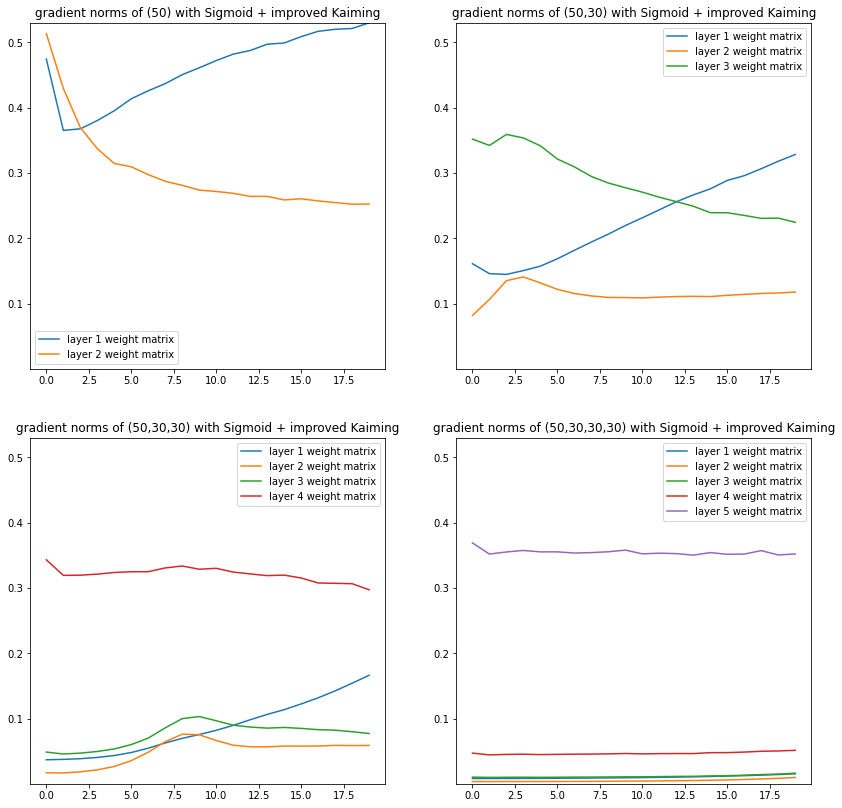

In [230]:
plot_gradient_norms(gradient_norms, "Sigmoid + improved Kaiming")

## b) Adaptive Learning Rates

In [195]:
class CIFAR10Dataset:
    def __init__(self, dataset='train', path='.'):
        path = Path(path)
        if dataset == 'train':
            batches = [self.load_batch(p) for p in path.glob('data_batch_*')]
            self.images = torch.cat([b for b, _ in batches])
            self.labels = torch.cat([b for _, b in batches])
        elif dataset == 'test':
            self.images, self.labels = self.load_batch(path / 'test_batch')
            
        # normalize
        self.images = self.images.float()
        self.labels = self.labels.long()
        
        std, mean = torch.std_mean(self.images, dim=0)
        self.images = (self.images - mean) / std
        
        assert len(self.images) == len(self.labels)
    
    def load_batch(self, path):
        with open(path, 'rb') as file:
            data_dict = pickle.load(file, encoding='bytes')
        images = data_dict[b'data'].reshape((-1, 32, 32, 3), order='F').swapaxes(1,2)
        images = torch.from_numpy(images)
        labels = torch.Tensor(data_dict[b'labels'])
        return images, labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return self.images[index], self.labels[index]

In [196]:
class Swish(nn.Module):
    def __init__(self, beta):
        super(Swish, self).__init__()
        self.beta = beta
    
    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)

In [197]:
train_dataset = CIFAR10Dataset('train','../data/cifar_10')
test_dataset = CIFAR10Dataset('test','../data/cifar_10')

train_dataloader = CUDADataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True))
test_dataloader = CUDADataLoader(DataLoader(test_dataset, batch_size=1_024, pin_memory=True))

In [198]:
make_model_fn = partial(MLPClassifier, input_size=32*32*3, output_size=10,
                        num_neurons=(512, 512), activation_type=partial(Swish, beta=1))

### off-the-shelf Adam

In [155]:
model_adam = make_model_fn().to('cuda:0')
optimizer_adam = torch.optim.Adam(model_adam.parameters())
accuracies_adam = np.zeros(50)

model_sgd = make_model_fn().to('cuda:0')
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.02)
accuracies_sgd = np.zeros(50)

for epoch in range(50):
    train(model_adam, train_dataloader, optimizer_adam)
    train(model_sgd, train_dataloader, optimizer_sgd)
    accuracies_adam[epoch] = accuracy(model_adam, test_dataloader)
    accuracies_sgd[epoch] = accuracy(model_sgd, test_dataloader)
    print(f"{epoch=:<2} acc_adam={accuracies_adam[epoch]:.4f} acc_sgd={accuracies_sgd[epoch]:.4f}")

epoch=0  acc_adam=0.4680 acc_sgd=0.4244
epoch=1  acc_adam=0.4991 acc_sgd=0.4664
epoch=2  acc_adam=0.4945 acc_sgd=0.4892
epoch=3  acc_adam=0.5097 acc_sgd=0.5011
epoch=4  acc_adam=0.5183 acc_sgd=0.4982
epoch=5  acc_adam=0.5235 acc_sgd=0.5206
epoch=6  acc_adam=0.5184 acc_sgd=0.5294
epoch=7  acc_adam=0.5145 acc_sgd=0.5190
epoch=8  acc_adam=0.5199 acc_sgd=0.5036
epoch=9  acc_adam=0.5246 acc_sgd=0.5398
epoch=10 acc_adam=0.5136 acc_sgd=0.5473
epoch=11 acc_adam=0.5229 acc_sgd=0.5507
epoch=12 acc_adam=0.5334 acc_sgd=0.5335
epoch=13 acc_adam=0.5242 acc_sgd=0.5158
epoch=14 acc_adam=0.5231 acc_sgd=0.5221
epoch=15 acc_adam=0.5232 acc_sgd=0.5411
epoch=16 acc_adam=0.5158 acc_sgd=0.5130
epoch=17 acc_adam=0.5241 acc_sgd=0.5184
epoch=18 acc_adam=0.5290 acc_sgd=0.5314
epoch=19 acc_adam=0.5344 acc_sgd=0.5330
epoch=20 acc_adam=0.5194 acc_sgd=0.5080
epoch=21 acc_adam=0.5199 acc_sgd=0.5485
epoch=22 acc_adam=0.5265 acc_sgd=0.5209
epoch=23 acc_adam=0.5204 acc_sgd=0.5001
epoch=24 acc_adam=0.5196 acc_sgd=0.5473


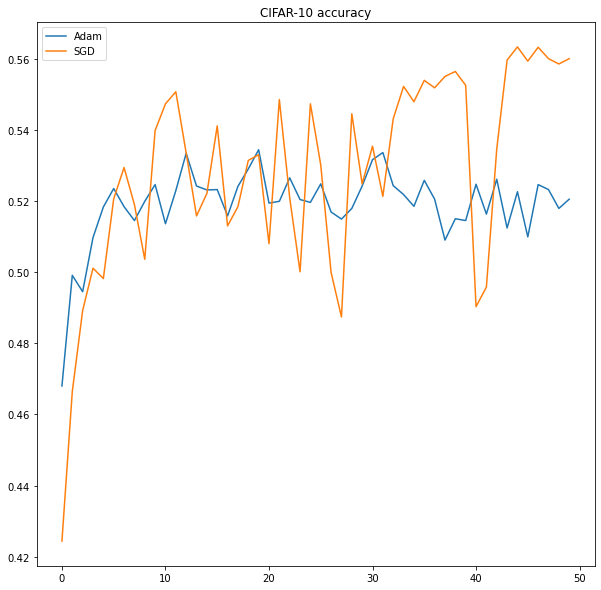

In [157]:
plt.figure(figsize=(10,10))

plt.plot(accuracies_adam, label="Adam")
plt.plot(accuracies_sgd, label="SGD")

plt.title("CIFAR-10 accuracy")
plt.legend()
plt.show()

### grid search

In [199]:
def cross_validate(model_factory, optimizer_factory, dataset, num_folds, num_epochs):
    fold_size = len(dataset) // num_folds
    splits = torch.utils.data.random_split(dataset, (fold_size,) * num_folds)
    accuracies = torch.zeros((num_folds, num_epochs))
    
    for i in range(num_folds):
        # prepare dataloaders
        train_dataset = ConcatDataset([*splits[:i], *splits[i+1:]])
        train_dataloader = CUDADataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True))
        test_dataloader = CUDADataLoader(DataLoader(splits[i], batch_size=1_024, pin_memory=True))
        
        # create model, train, validate
        model = model_factory().to('cuda:0')
        optimizer = optimizer_factory(model.parameters())
        
        print(f" - fold {i+1}, epoch ", end="")
        for epoch in range(num_epochs):
            train(model, train_dataloader, optimizer)
            accuracies[i, epoch] = accuracy(model, test_dataloader)
            print(f"{epoch+1}{',' if epoch != num_epochs-1 else ''}", end="")
        print()
    
    return accuracies.mean(dim=0)

In [201]:
def cross_validate_learning_rates(learning_rates):
    mean_accuracies = []
    for lr in learning_rates:
        print(f"{lr=:.5f}")
        print()
        make_optimizer_fn = partial(torch.optim.Adam, lr=lr)
        mean_acc = cross_validate(make_model_fn, make_optimizer_fn, train_dataset, num_folds=5, num_epochs=10)
        mean_accuracies.append(mean_acc)
        print()
        print(f"mean accuracy: {mean_acc[-1]:.4f}")
        print("-"*20)
    return mean_accuracies

In [202]:
# grid search
learning_rates = [10**(-k) for k in range(1,6)]
mean_accuracies = cross_validate_learning_rates(learning_rates)

lr=0.10000

 - fold 1, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 2, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 3, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 4, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 5, epoch 1,2,3,4,5,6,7,8,9,10

mean accuracy: 0.0999
--------------------
lr=0.01000

 - fold 1, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 2, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 3, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 4, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 5, epoch 1,2,3,4,5,6,7,8,9,10

mean accuracy: 0.1001
--------------------
lr=0.00100

 - fold 1, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 2, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 3, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 4, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 5, epoch 1,2,3,4,5,6,7,8,9,10

mean accuracy: 0.5087
--------------------
lr=0.00010

 - fold 1, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 2, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 3, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 4, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 5, epoch 1,2,3,4,5,6,7,8,9,10

mean accuracy: 0.5508
--------------------
lr=0.00001

 - f

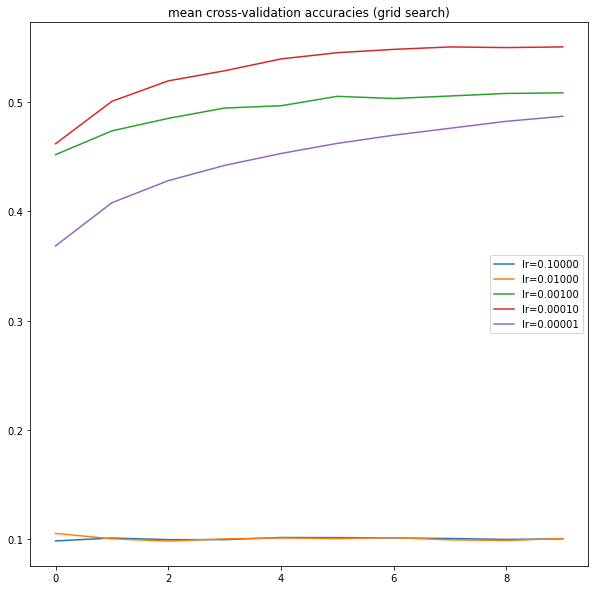

In [203]:
plt.figure(figsize=(10,10))

for lr, mean_acc in zip(learning_rates, mean_accuracies):
    plt.plot(mean_acc, label=f"{lr=:.5f}")

plt.legend()
plt.title("mean cross-validation accuracies (grid search)")
plt.show()

### random search

In [204]:
# random search
learning_rates = [10**(-k) for k in np.random.rand(5) * 4 + 1]
mean_accuracies = cross_validate_learning_rates(learning_rates)

lr=0.00015

 - fold 1, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 2, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 3, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 4, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 5, epoch 1,2,3,4,5,6,7,8,9,10

mean accuracy: 0.5473
--------------------
lr=0.00008

 - fold 1, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 2, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 3, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 4, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 5, epoch 1,2,3,4,5,6,7,8,9,10

mean accuracy: 0.5504
--------------------
lr=0.00071

 - fold 1, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 2, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 3, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 4, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 5, epoch 1,2,3,4,5,6,7,8,9,10

mean accuracy: 0.5134
--------------------
lr=0.00001

 - fold 1, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 2, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 3, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 4, epoch 1,2,3,4,5,6,7,8,9,10
 - fold 5, epoch 1,2,3,4,5,6,7,8,9,10

mean accuracy: 0.4889
--------------------
lr=0.00044

 - f

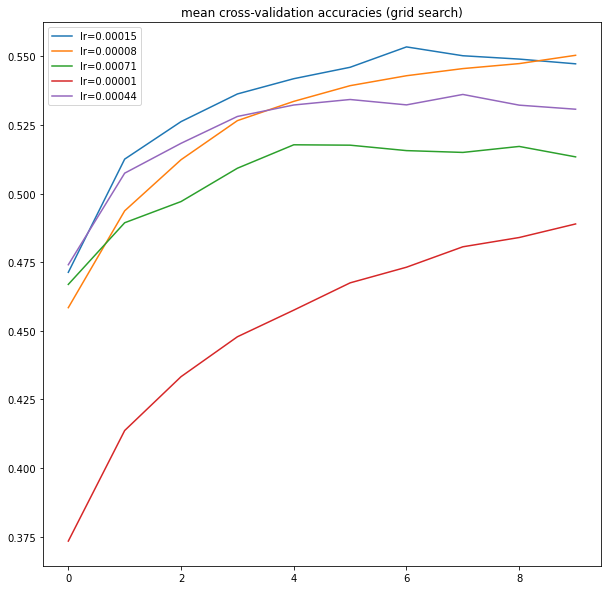

In [205]:
plt.figure(figsize=(10,10))

for lr, mean_acc in zip(learning_rates, mean_accuracies):
    plt.plot(mean_acc, label=f"{lr=:.5f}")

plt.legend()
plt.title("mean cross-validation accuracies (grid search)")
plt.show()